In [1]:
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

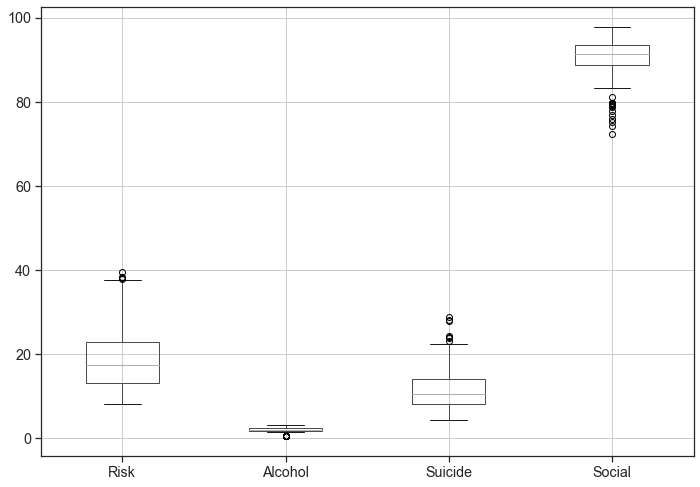

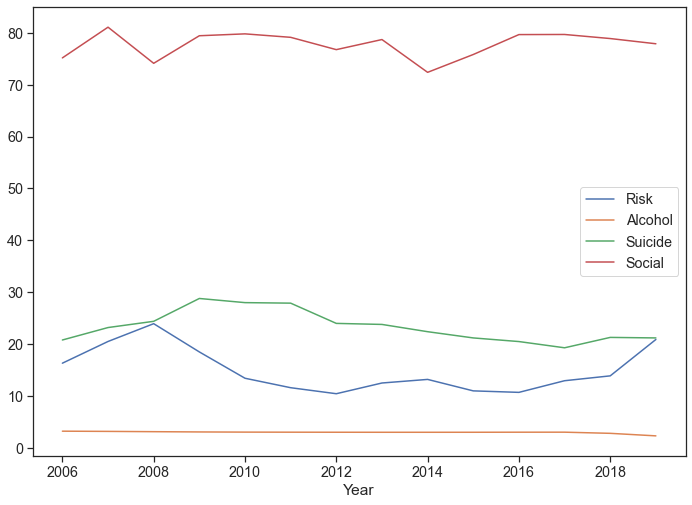

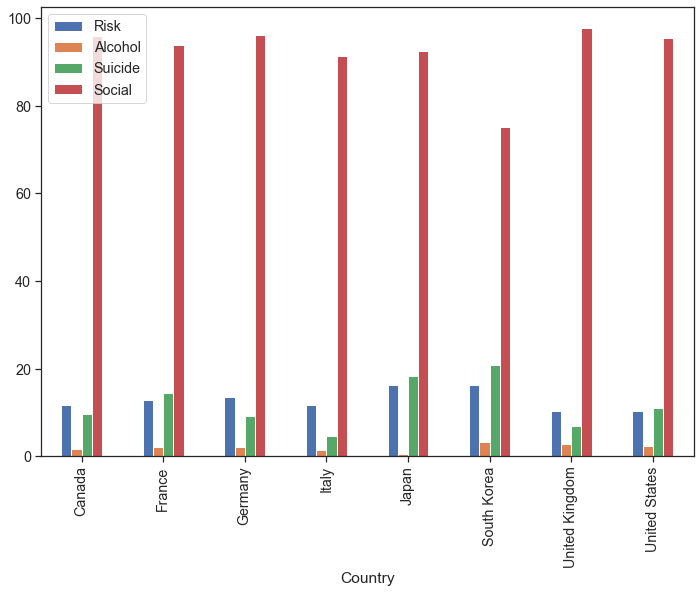

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Alcohol: -0.2986015283320355
Suicide: -0.1312161839045365
Social: 0.058699853348999756


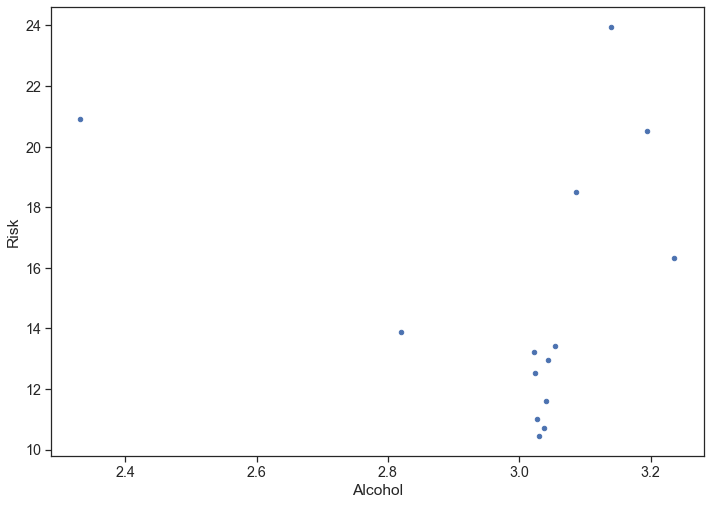

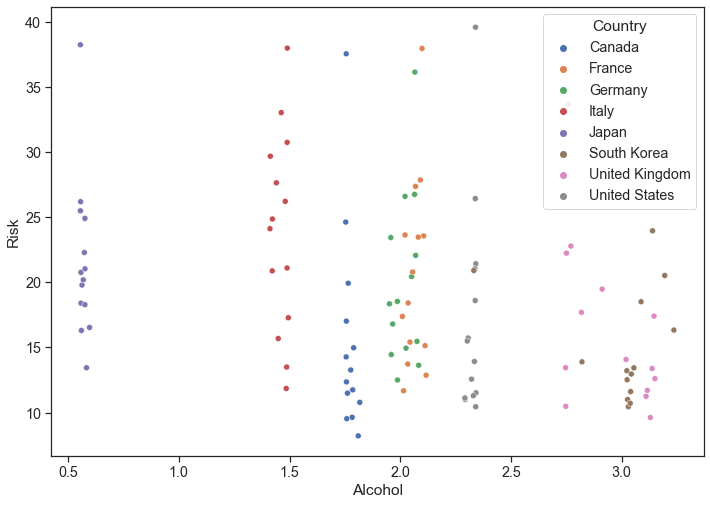

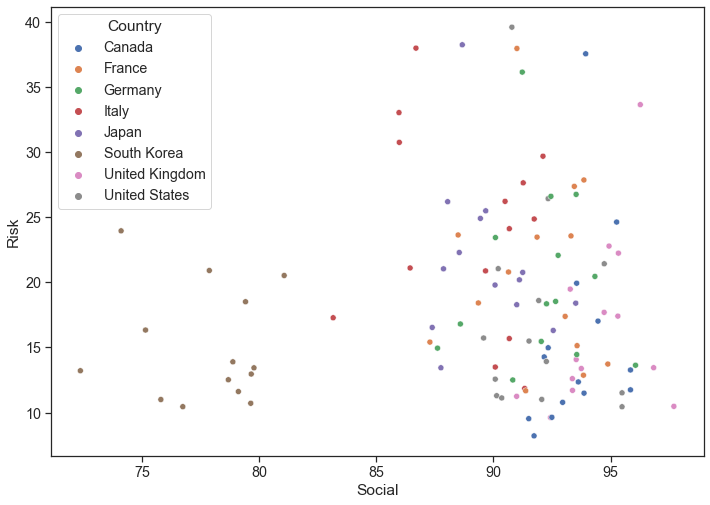

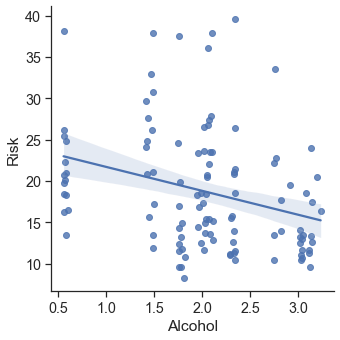

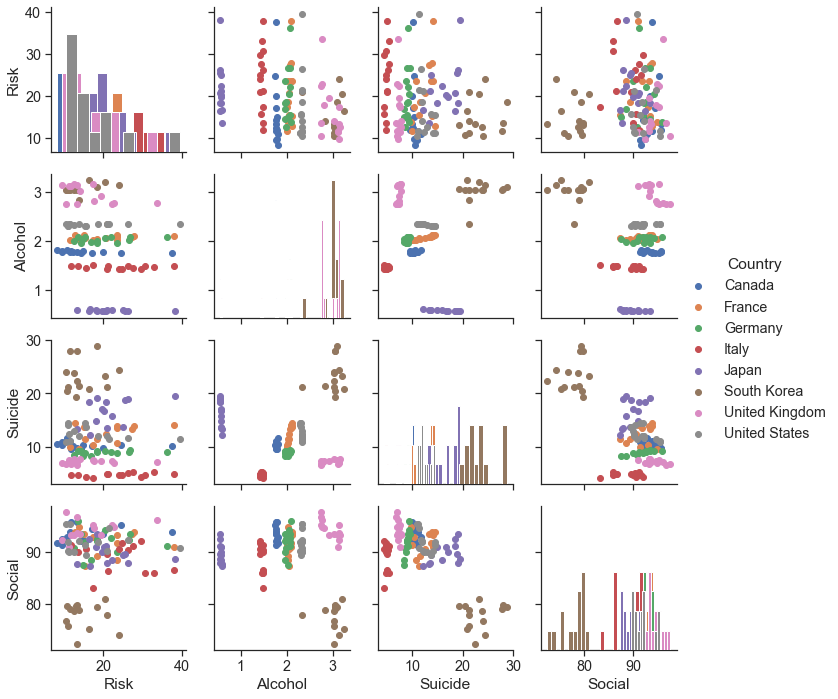

In [2]:
%run Data_Master.ipynb

### Simple Linear Regression

In [3]:
# Simple Linear Regression

def SLR(indep, dep = "Risk", scale = "Y"):
    
    X = df[[indep]]
    y = df[dep]
    
    if scale == "Y":   # Default mode leads to scaling
        scaler = StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X = X_scaled
    
    model = linear_model.LinearRegression()
    model.fit(X,y)
    
    weight = model.coef_
    intercept = model.intercept_
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    pvalue = est2.f_pvalue
    
    y_pred = model.predict(X)
    r2 = r2_score(df["Risk"], y_pred)
    
    print(f"Regression --- x = {indep.lower()}, y = {dep.lower()}")
    print(f"y = {weight[0]:.2f} x + {intercept:.2f}")
    print(f"p-value = {pvalue}")
    print("R2:",f"{r2:.5f}")
    print("-------------------------------------------")

In [4]:
indep_vars = attributes_corr

for attr in indep_vars:
    SLR(attr)

Regression --- x = alcohol, y = risk
y = -2.17 x + 18.75
p-value = 0.001384142634474714
R2: 0.08916
-------------------------------------------
Regression --- x = suicide, y = risk
y = -0.95 x + 18.75
p-value = 0.1678782744681569
R2: 0.01722
-------------------------------------------
Regression --- x = social, y = risk
y = 0.43 x + 18.75
p-value = 0.5386985778304691
R2: 0.00345
-------------------------------------------


### Multivariate Linear Regression

In [5]:
# Check correlation

df_corr = df[attributes].corr()
df_corr

,Risk,Alcohol,Suicide,Social
Risk,1.000000,-0.298602,-0.131216,0.058700
Alcohol,-0.298602,1.000000,0.150909,-0.235346
Suicide,-0.131216,0.150909,1.000000,-0.665686
Social,0.058700,-0.235346,-0.665686,1.000000


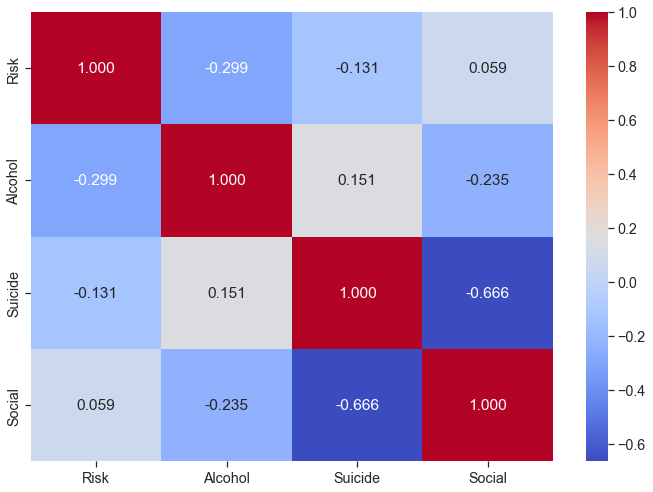

In [6]:
heatmap = sns.heatmap(df_corr, cmap = "coolwarm", annot = True, fmt = ".3f")

#fig = heatmap.get_figure()
#fig.savefig("heatmap.png") 

Since alcohol, suicide and social are correlated, multivariate linear regression is flawed.

However, we find the regression to get the sketch.

In [7]:
X = df[indep_vars]
y = df["Risk"]
    
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X = X_scaled
    
model = linear_model.LinearRegression()
model.fit(X,y)
    
weight = model.coef_
intercept = model.intercept_

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
pvalue = est2.f_pvalue
    
y_pred = model.predict(X)
r2 = r2_score(df["Risk"], y_pred)
    
print(weight, intercept)
print(pvalue)
print(r2)

[-2.19866469 -1.2253238  -0.90649748] 18.754921749999998
0.007209531371178813
0.10513145335904006


### Principal Component Analysis

In [8]:
def my_PCA(data, dimension = 2):
    
    X = data[indep_vars]
    y = data["Risk"]
    
    # scale attributes before decomposition
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    # principal component analysis
    pca = PCA(n_components=dimension)
    pca.fit(X_scaled)
    attr_pca = pca.transform(X_scaled)

    # construct new DataFrame containing the result of PCA
    col = []
    for i in range(dimension):
        col.append(f"pc_{i+1}")
    df_pca = pd.DataFrame(attr_pca, columns = col)
    df_pca["Risk"] = list(data["Risk"])
    
    # 0: df, 1: explained variance ratio, 2: loading
    return df_pca, pca.explained_variance_ratio_[0], list(pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_))[0])
    

In [9]:
my_PCA(df)

(         pc_1      pc_2      Risk
 0   -1.120122 -0.021598  11.74154
 1   -0.159121 -0.109824  12.86654
 2   -1.048037 -0.416740  13.63169
 3   -1.255714  0.229151  11.84762
 4   -0.232103  2.093638  16.30069
 ..        ...       ...       ...
 107 -0.266462  0.454435  17.27391
 108 -0.285151  1.873017  16.53054
 109  2.744277  0.498276  20.90015
 110 -0.522723 -1.752235  11.70249
 111  0.229435 -0.262901  15.48678
 
 [112 rows x 3 columns],
 0.5878952873311412,
 [0.4504869142851577, 0.8744674243962105, -0.9010789019508123])

In [10]:
df_pca = my_PCA(df)[0]

X = df_pca[["pc_1"]]
y = df_pca["Risk"]
        
# Linear Regression
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
est2.summary()

/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Risk   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     3.296
Date:                Wed, 28 Feb 2024   Prob (F-statistic):             0.0722
Time:                        15:36:09   Log-Likelihood:                -379.42
No. Observations:                 112   AIC:                             762.8
Df Residuals:                     110   BIC:                             768.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.7549      0.683     27.467      0.000      17.402      20.108
pc_1          -0.9334      0.514     -1.815      0.072      -1.952       0.086
==============================================================================
Omnibus:                       16.570   Durbin-Watson:                   0.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.880
Skew:                           0.965   Prob(JB):                     7.95e-05
Kurtosis:                       3.569   Cond. No.                         1.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

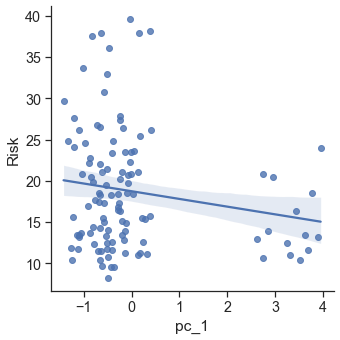

In [11]:
pca_reg = sns.lmplot(x = "pc_1", y = "Risk", data = df_pca).fig
#fig = pca_reg.get_figure()
#fig.savefig("pca_reg.png") 

We have constructed a mental illness index.
Now we want to see how feasible this index is.

In [12]:
# comparison between US GDP and US mental illness index

df_GDP = pd.read_csv("real_gdp_us.csv")
df_GDP["Mental Illness Index"] = list(my_PCA(df[df["Country"]=="United States"])[0]["pc_1"])

scaler = StandardScaler().fit(df_GDP[["GDP"]])
GDP_scaled = scaler.transform(df_GDP[["GDP"]])

scaler = StandardScaler().fit(df_GDP[["Mental Illness Index"]])
mental_scaled = scaler.transform(df_GDP[["Mental Illness Index"]])

df_GDP["GDP"] = GDP_scaled
df_GDP["Mental Illness Index"] = mental_scaled

<AxesSubplot:xlabel='DATE'>

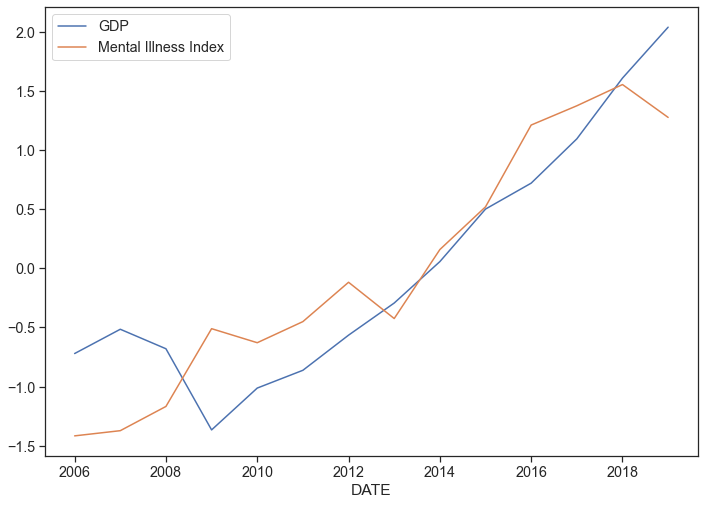

In [13]:
df_GDP.plot.line(x="DATE")

In [14]:
# comparison between US Stock Market Volatility and US mental illness index

df_plot = pd.DataFrame()

df_plot["Risk"] = list(df[df["Country"]=="United States"]["Risk"])

scaler = StandardScaler().fit(df_plot[["Risk"]])
risk_scaled = scaler.transform(df_plot[["Risk"]])

df_plot["Risk"] = risk_scaled

df_plot["Mental Illness Index"] = mental_scaled
df_plot["Year"] = df_GDP["DATE"]

<AxesSubplot:xlabel='Year'>

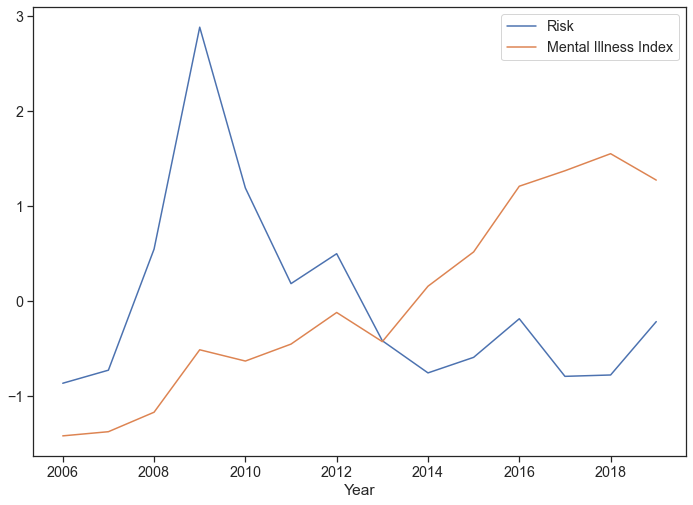

In [15]:
df_plot.plot.line(x = "Year")

In [16]:
# Linear Regression using PC_1

# Enter Mode = "Full" for full stats
def SLR_PCA(Hue, Mode = "Simple"):
    
    hue_list = list(df[Hue].unique())
    weight_list = []
    intercept_list = []
    p_value_list = []
    loading_list = []
    
    for i in hue_list:
        
        df_sliced = df[df[Hue]==i]
        result = my_PCA(df_sliced) # initiate PCA
        df_pca = result[0] # call df
        
        if Mode == "Full":
            print(f"{Hue} = {i}")
            print("Expalined Variance Ratio:", result[1])
            print("Loadings:", result[2])
        
        X = df_pca[["pc_1"]]
        y = df_pca["Risk"]
        
        # Linear Regression
        model = linear_model.LinearRegression()
        model.fit(X, y)
        weight = model.coef_
        intercept = model.intercept_
    
        y_pred = model.predict(X)
        
        X2 = sm.add_constant(X)
        est = sm.OLS(y, X2)
        est2 = est.fit()
        p_value = est2.f_pvalue
        r2 = r2_score(df_pca["Risk"], y_pred)
        
        if Mode == "Full":
            print(f"Regression --- x = pc_1, y = risk")
            print(f"y = {weight[0]:.2f} x + {intercept:.2f}")
            print("R2:",f"{r2:.5f}")
            sns.lmplot(x = "pc_1", y = "Risk", data = df_pca)
            print("-------------------------------------------")
            
        weight_list.append(weight[0])
        intercept_list.append(intercept)
        p_value_list.append(p_value)
        loading_list.append(result[2])
        
    return hue_list, weight_list, intercept_list, p_value_list, loading_list

Country = Canada
Expalined Variance Ratio: 0.557801689257297
Loadings: [0.753875324997392, 0.8405424432207618, -0.726146631217225]
Regression --- x = pc_1, y = risk
y = -2.67 x + 15.38
R2: 0.21378
-------------------------------------------
Country = France
Expalined Variance Ratio: 0.7211871481035559
Loadings: [1.007658858097226, 0.9722574461652214, 0.6077238943744607]
Regression --- x = pc_1, y = risk
y = 1.68 x + 20.65
R2: 0.12433


/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


-------------------------------------------
Country = Germany
Expalined Variance Ratio: 0.7240707388425506
Loadings: [-0.6755594825153524, -0.9704832656845617, -0.9700964284867122]
Regression --- x = pc_1, y = risk
y = -1.05 x + 20.00
R2: 0.06007
-------------------------------------------
Country = Italy
Expalined Variance Ratio: 0.5443130326535852
Loadings: [0.9374884661988696, -0.04486481745138377, -0.9368309995420921]
Regression --- x = pc_1, y = risk
y = 0.20 x + 23.89
R2: 0.00118


/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


-------------------------------------------
Country = Japan
Expalined Variance Ratio: 0.7831621304602595
Loadings: [0.9874824600240305, -0.9936976380543743, -0.7534318211123895]
Regression --- x = pc_1, y = risk
y = -1.24 x + 21.55
R2: 0.10646
-------------------------------------------
Country = South Korea
Expalined Variance Ratio: 0.4239502600859542
Loadings: [-0.5900172346295793, -0.8712321040994833, -0.5123668015091977]
Regression --- x = pc_1, y = risk
y = 0.09 x + 15.00
R2: 0.00062


/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


-------------------------------------------
Country = United Kingdom
Expalined Variance Ratio: 0.7199900658562608
Loadings: [-0.9182698399906575, -0.7894809149139631, 0.92715809718627]
Regression --- x = pc_1, y = risk
y = 1.57 x + 16.41
R2: 0.13566
-------------------------------------------
Country = United States
Expalined Variance Ratio: 0.7852572258329982
Loadings: [-0.9755445047051311, 1.008868748745734, -0.7533137796458362]
Regression --- x = pc_1, y = risk
y = -1.38 x + 17.15
R2: 0.07467


/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


-------------------------------------------


(['Canada',
  'France',
  'Germany',
  'Italy',
  'Japan',
  'South Korea',
  'United Kingdom',
  'United States'],
 [-2.6722214877140327,
  1.6753082021807881,
  -1.046218222630752,
  0.1986795217996546,
  -1.235670941618951,
  0.09165776987304103,
  1.5723237617194028,
  -1.3836527748724161],
 [15.381143785714286,
  20.654239285714286,
  20.003306428571427,
  23.88868642857142,
  21.554033571428565,
  14.997839285714287,
  16.409173071428572,
  17.150952142857147],
 [0.09599024963097978,
  0.21627163904749835,
  0.39835887621638405,
  0.9071040371609047,
  0.25490741640737075,
  0.9329192770736006,
  0.19505663782127677,
  0.34450274606971243],
 [[0.753875324997392, 0.8405424432207618, -0.726146631217225],
  [1.007658858097226, 0.9722574461652214, 0.6077238943744607],
  [-0.6755594825153524, -0.9704832656845617, -0.9700964284867122],
  [0.9374884661988696, -0.04486481745138377, -0.9368309995420921],
  [0.9874824600240305, -0.9936976380543743, -0.7534318211123895],
  [-0.5900172346295

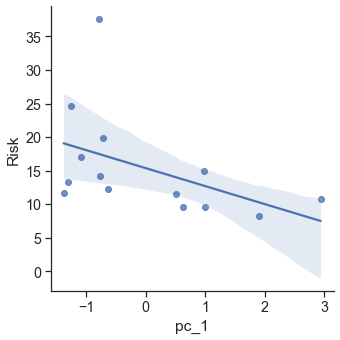

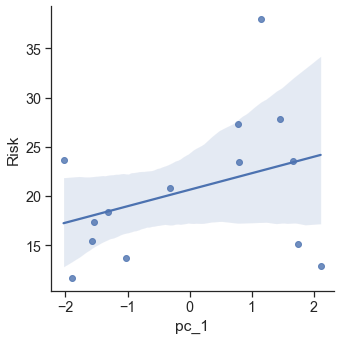

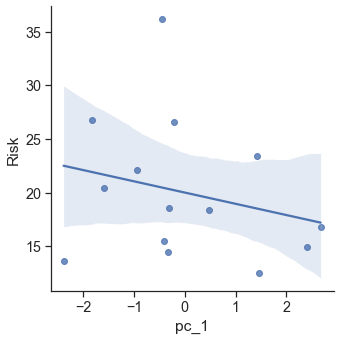

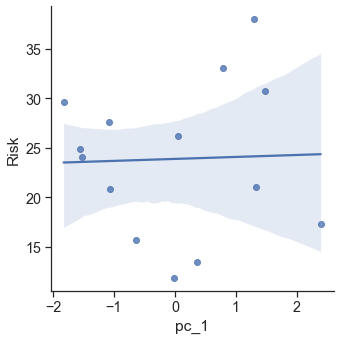

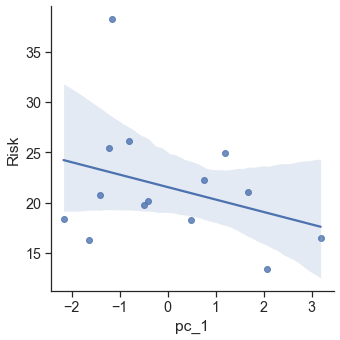

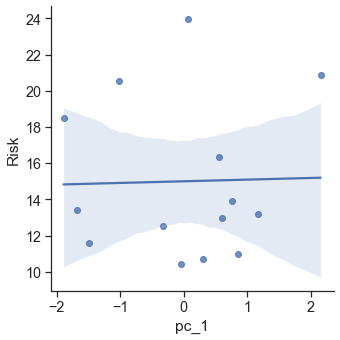

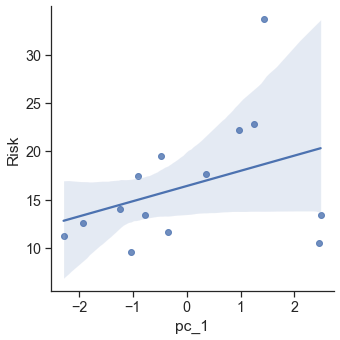

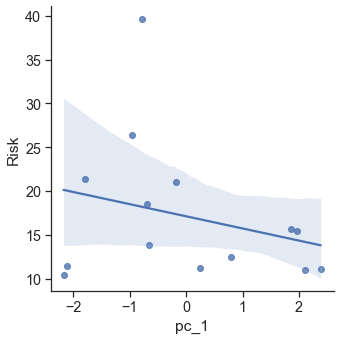

In [17]:
SLR_PCA("Country", Mode = "Full") # The case for Canada is worth noting

In [18]:
# statistical inference

df_stats = pd.DataFrame()

index = SLR_PCA("Year")[0]
weights = SLR_PCA("Year")[1]
p_vals = SLR_PCA("Year")[3]
loadings = SLR_PCA("Year")[4]

validity = []

# make column indicating whether each test was statistically significant
for p_val in p_vals:
    if p_val <= 0.1:
        validity.append(1)
    else:
        validity.append(0)

# make column containing loadings
loading = {}

for cnt in range(3):
    loading[cnt] = []

for loading_array in loadings:
    for cnt in range(3):
        loading[cnt].append(loading_array[cnt])

df_stats["index"] = index
df_stats["weights"] = weights
df_stats["significance"] = validity
df_stats["p values"] = p_vals
df_stats["loading_alcohol"] = loading[0]
df_stats["loading_suicide"] = loading[1]
df_stats["loading_social"] = loading[2]

/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/jacobbyun/opt/ana

In [19]:
df_stats

,index,weights,significance,p values,loading_alcohol,loading_suicide,loading_social
0,2006,1.084797,1,0.070965,0.555559,0.870624,-0.997626
1,2007,1.660036,1,0.020442,0.573081,0.849670,-0.967689
2,2008,0.706609,0,0.193411,0.412822,0.948438,-0.972662
3,2009,-4.086609,1,0.007458,0.379096,0.980691,-0.968838
4,2010,-3.004786,1,0.012912,0.432415,0.945161,-0.937653
5,2011,-2.002621,1,0.088318,0.539424,0.970716,-1.014732
6,2012,-3.161308,1,0.084870,0.532396,0.907361,-0.957448
7,2013,-1.569981,0,0.269134,0.546223,0.958862,-1.024921
8,2014,-0.672696,0,0.601437,0.557905,0.951076,-1.021919
9,2015,-1.754732,0,0.143187,0.595529,0.935529,-1.007436
